# Exploration of the data and fast modeling

In [29]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from darts.metrics import mape, smape
from darts.utils.statistics import plot_acf, check_seasonality
from darts.utils.timeseries_generation import linear_timeseries, sine_timeseries
from darts import TimeSeries
import category_encoders as ce
import logging

### Useful functions

In [2]:
# calculate the smape
def compute_smape(y_true, y_pred):

    if not (isinstance(y_true, np.ndarray) and isinstance(y_pred, np.ndarray)):
        y_true, y_pred = np.array(y_true), np.array(y_pred)

    return round(np.mean(
        np.abs(y_pred - y_true) /
        ((np.abs(y_pred) + np.abs(y_true))/2)
    )*100, 3)# some configuration


### Load data

In [3]:
series_train_data = pd.read_csv('../../data/godaddy-microbusiness-density-forecasting/train.csv')
series_test_data = pd.read_csv('../../data/godaddy-microbusiness-density-forecasting/test.csv')
census_data = pd.read_csv('../../data/godaddy-microbusiness-density-forecasting/census_ae.csv')

series_train_data.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
series_test_data.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [5]:
census_data.head()

,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc,cfips
0,2019,76.6,14.5,2.1,1.3,55317.0,1001
1,2019,74.5,20.4,3.2,1.4,52562.0,1003
2,2019,57.2,7.6,2.7,0.5,33368.0,1005
3,2019,62.0,8.1,1.0,1.2,43404.0,1007
4,2019,65.8,8.7,4.5,1.3,47412.0,1009


###  Merge all data

In [6]:
# add a column source in train and test
series_train_data['source'] = 'train'
series_test_data['source'] = 'test'

In [7]:
# merge train and test
series_data = pd.concat([series_train_data, series_test_data], axis=0)

In [8]:
series_data.sample(5)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,source
5121,37199_2022-12-01,37199,NaN,NaN,2022-12-01,NaN,NaN,test
76920,37171_2020-08-01,37171,Surry County,North Carolina,2020-08-01,3.380770,1910.0,train
93790,46093_2022-06-01,46093,Meade County,South Dakota,2022-06-01,5.331492,1158.0,train
118794,55013_2019-08-01,55013,Burnett County,Wisconsin,2019-08-01,2.371795,296.0,train
37678,20161_2019-12-01,20161,Riley County,Kansas,2019-12-01,5.378344,3384.0,train


In [9]:
census_data['year'].unique()

array([2019, 2020, 2021, 2022, 2023], dtype=int64)

In [10]:
# extract year from first_day_of_month column

series_data['year'] = series_data['first_day_of_month'].apply(lambda x: int(x.split('-')[0]))
series_data['year'].unique()

array([2019, 2020, 2021, 2022, 2023], dtype=int64)

In [11]:
series_data.shape

(147345, 9)

In [12]:
# merge series
data = pd.merge(series_data, census_data, on=['cfips', 'year'], how='left')

data

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,source,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,train,2019,76.6,14.5,2.1,1.3,55317.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,train,2019,76.6,14.5,2.1,1.3,55317.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,train,2019,76.6,14.5,2.1,1.3,55317.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,train,2019,76.6,14.5,2.1,1.3,55317.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,train,2019,76.6,14.5,2.1,1.3,55317.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56037_2023-06-01,56037,NaN,NaN,2023-06-01,NaN,NaN,test,2023,88.4,12.4,5.5,1.0,76668.0
147341,56039_2023-06-01,56039,NaN,NaN,2023-06-01,NaN,NaN,test,2023,90.5,38.3,11.1,2.0,94498.0
147342,56041_2023-06-01,56041,NaN,NaN,2023-06-01,NaN,NaN,test,2023,90.6,12.3,2.9,0.9,75106.0
147343,56043_2023-06-01,56043,NaN,NaN,2023-06-01,NaN,NaN,test,2023,85.4,17.2,1.0,1.1,62271.0


In [13]:
data.tail()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,source,year,pct_bb,pct_college,pct_foreign_born,pct_it_workers,median_hh_inc
147340,56037_2023-06-01,56037,NaN,NaN,2023-06-01,NaN,NaN,test,2023,88.4,12.4,5.5,1.0,76668.0
147341,56039_2023-06-01,56039,NaN,NaN,2023-06-01,NaN,NaN,test,2023,90.5,38.3,11.1,2.0,94498.0
147342,56041_2023-06-01,56041,NaN,NaN,2023-06-01,NaN,NaN,test,2023,90.6,12.3,2.9,0.9,75106.0
147343,56043_2023-06-01,56043,NaN,NaN,2023-06-01,NaN,NaN,test,2023,85.4,17.2,1.0,1.1,62271.0
147344,56045_2023-06-01,56045,NaN,NaN,2023-06-01,NaN,NaN,test,2023,81.3,13.9,1.6,0.0,65566.0


In [14]:
keep_col = [ 'source', 'row_id', 'cfips', 'first_day_of_month', 'microbusiness_density', 'pct_bb', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc']

data = data[keep_col]

In [15]:
data.head()

,source,row_id,cfips,first_day_of_month,microbusiness_density,pct_bb,pct_foreign_born,pct_it_workers,median_hh_inc
0,train,1001_2019-08-01,1001,2019-08-01,3.007682,76.6,2.1,1.3,55317.0
1,train,1001_2019-09-01,1001,2019-09-01,2.884870,76.6,2.1,1.3,55317.0
2,train,1001_2019-10-01,1001,2019-10-01,3.055843,76.6,2.1,1.3,55317.0
3,train,1001_2019-11-01,1001,2019-11-01,2.993233,76.6,2.1,1.3,55317.0
4,train,1001_2019-12-01,1001,2019-12-01,2.993233,76.6,2.1,1.3,55317.0


In [16]:
# encode data
data['cfips_cat'] = data['cfips']

data = ce.BaseNEncoder(cols=['cfips_cat'], base=10).fit_transform(data)

data.head()

C:\Users\avomo\AppData\Local\Temp\ipykernel_9644\3723858511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cfips_cat'] = data['cfips']


,source,row_id,cfips,first_day_of_month,microbusiness_density,pct_bb,pct_foreign_born,pct_it_workers,median_hh_inc,cfips_cat_0,cfips_cat_1,cfips_cat_2,cfips_cat_3
0,train,1001_2019-08-01,1001,2019-08-01,3.007682,76.6,2.1,1.3,55317.0,0,0,0,1
1,train,1001_2019-09-01,1001,2019-09-01,2.884870,76.6,2.1,1.3,55317.0,0,0,0,1
2,train,1001_2019-10-01,1001,2019-10-01,3.055843,76.6,2.1,1.3,55317.0,0,0,0,1
3,train,1001_2019-11-01,1001,2019-11-01,2.993233,76.6,2.1,1.3,55317.0,0,0,0,1
4,train,1001_2019-12-01,1001,2019-12-01,2.993233,76.6,2.1,1.3,55317.0,0,0,0,1


In [17]:
#data.to_pickle('../../data/merged_data.pickle')

###  Modeling with darts

In [43]:
data.columns

Index(['source', 'row_id', 'cfips', 'first_day_of_month',
       'microbusiness_density', 'pct_bb', 'pct_foreign_born', 'pct_it_workers',
       'median_hh_inc', 'cfips_cat_0', 'cfips_cat_1', 'cfips_cat_2',
       'cfips_cat_3'],
      dtype='object')

In [18]:
from darts.models import XGBModel, LightGBMModel, RNNModel, BlockRNNModel,NBEATSModel

In [44]:
# first convert the data to darts format

# select only train source
train_data = data[data['source'] == 'train']

# series values
series_train = TimeSeries.from_group_dataframe(train_data, group_cols=['cfips'], value_cols=['microbusiness_density'], time_col='first_day_of_month')
print(f'train series: {len(series_train)}')


# covariates
covariates_train = TimeSeries.from_group_dataframe(train_data, group_cols=['cfips'], time_col='first_day_of_month', value_cols=['cfips_cat_0', 'cfips_cat_1', 'cfips_cat_2', 'cfips_cat_3', 'pct_bb', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc'])
len(covariates_train)

train series: 3135


3135

In [48]:
# split train and eval
EVAL_LENGTH = 6

series_train_train = [ s[:-EVAL_LENGTH] for s in series_train ]
covariates_train_train = [ s[:-EVAL_LENGTH] for s in covariates_train ]

series_train_eval = [ s[-EVAL_LENGTH:] for s in series_train ]
covariates_train_eval = [ s[-EVAL_LENGTH:] for s in covariates_train ]



In [21]:
def eval_model( model, dt_values, past_covariates = None ):

    backtests = model.historical_forecasts(series =dt_values, past_covariates=past_covariates, start=pd.Timestamp('2021-12-01'), retrain=False, verbose=True, forecast_horizon=EVAL_LENGTH)

    #dt_values.plot(label='actual')
    #backtest.plot(label='forecast (n=10)')

    error = np.mean( [ smape(dt_val, bt) for dt_val,bt in zip(dt_values, backtests) ] )


    print(f'Backtest SMAPE = {error}')

    return error


#### Simple RNN Without Covariates

In [35]:
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

In [34]:
brnn_no_cov = BlockRNNModel(input_chunk_length=6,
                            output_chunk_length=1,
                            n_rnn_layers=1,
                            pl_trainer_kwargs={
                                "accelerator": "gpu",
                                "devices": [0],
                            })

brnn_no_cov.fit(series_train_train,
                epochs=5,
                verbose=True)

#eval_model(brnn_no_cov)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


12.269662657540088

In [ ]:
# select a random idx
#idx = random.randint(0, len(series_train))
#dt_values = series_train[idx]


error = eval_model( brnn_no_cov, series_train[:100] )

In [39]:
error

12.269662657540088

#### With Covariates

In [ ]:
model_cov =  BlockRNNModel(input_chunk_length=6,
                            output_chunk_length=1,
                            n_rnn_layers=3,
                            hidden_dim=50,
                            pl_trainer_kwargs={
                                "accelerator": "gpu",
                                "devices": [0],
                            })

model_cov.fit(series_train_train, past_covariates=covariates_train_train,
                epochs=20,
                verbose=True)

Training: 0it [00:00, ?it/s]

In [54]:
error

63.60365320298213

In [ ]:
error = eval_model( model_cov, series_train[:100], past_covariates=covariates_train[:100] )

In [30]:
# split train and eval
EVAL_LENGTH = 6
series_train_train = [ s[:-EVAL_LENGTH] for s in series_train ]
covariates_train_train = [ s[:-EVAL_LENGTH] for s in covariates_train ]
series_train_eval = [ s[-EVAL_LENGTH:] for s in series_train ]
covariates_train_eval = [ s[-EVAL_LENGTH:] for s in covariates_train ]

In [31]:
#len(series_train)

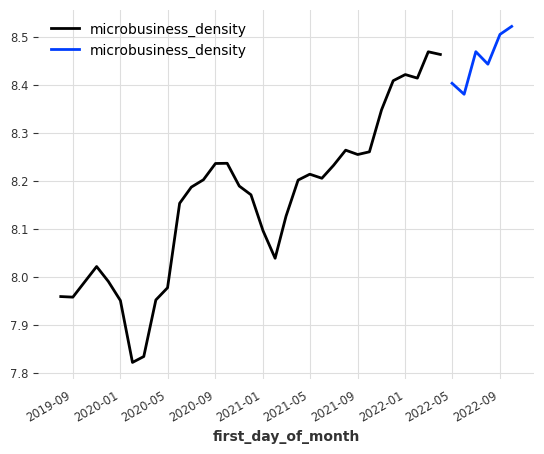

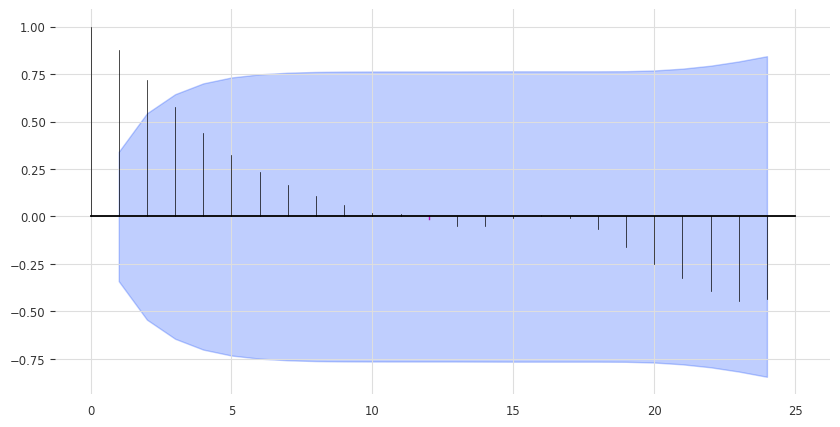

In [32]:
idx = random.randint(0, len(series_train))
series_train_train[idx].plot()
series_train_eval[idx].plot()
plot_acf(series_train_train[idx], m=12, alpha=0.05)

In [33]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(series_train_train[idx], m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

In [101]:
from darts.models import RNNModel
from darts.metrics import mase, smape

#### NBEATS

In [102]:
model = NBEATSModel(input_chunk_length = 12, output_chunk_length = 4, generic_architecture=True, num_stacks=5, num_blocks=1, num_layers=2, layer_widths=32, dropout=0.0, activation='ReLU', n_epochs=5,
                    pl_trainer_kwargs={
                        "accelerator": "gpu",
                        "devices": [0]
                    })

model.fit(series_train_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.5 K 
---------------------------------------------------
9.3 K     Trainable params
237       Non-trainable params
9.5 K     Total params
0.076     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [103]:
pred_nocov = model.predict(n=6, series=series_train_train)
smape_err = np.mean( [ smape(series_train_eval[i], pred_nocov[i]) for i in range(len(series_train_train))]  )
print("MASE error: {:.2f}".format(smape_err))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

MASE error: 27.35


#### XGBoost

In [53]:
series1 = sine_timeseries(length=400, value_frequency=0.08)
series2 = sine_timeseries(length=400, value_frequency=0.007)
target = series1 * series2
covariates = series2

In [54]:
target_train, target_val = target[:300], target[300:]
cov_train, cov_val = covariates[:300], covariates[300:]

In [82]:
model_nocov = BlockRNNModel(input_chunk_length=4,
                            output_chunk_length=4,
                            hidden_dim=50,
                            dropout=0.05,
                            n_epochs=5,
                            pl_trainer_kwargs={
                                "accelerator": "gpu",
                                "devices": [0]
                            })
model_nocov.fit(series_train_train)

C:\Users\avomo\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.6 K 
4 | fc            | Sequential       | 204   
---------------------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.023     Total est

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [83]:
pred_nocov = model_nocov.predict(n=6, series=series_train_train)
smape_err = np.mean( [ smape(series_train_eval[i], pred_nocov[i]) for i in range(len(series_train_train))]  )
print("MASE error: {:.2f}".format(smape_err))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

MASE error: 3.92


### With covariates

In [98]:
model_cov = BlockRNNModel(input_chunk_length=4,
                        output_chunk_length=1,
                        hidden_dim=50,
                        model='GRU',
                        dropout=0.05,
                        n_epochs=5,
                        pl_trainer_kwargs={
                            "accelerator": "gpu",
                            "devices": [0]
            })

model_cov.fit(series_train_train, past_covariates=covariates_train_train)

C:\Users\avomo\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.05 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | GRU              | 9.2 K 
4 | fc            | Sequential       | 51    
---------------------------------------------------
9.2 K     Trainable params
0         Non-trainable params
9.2 K     Total params
0.074     Total est

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [100]:
pred_nocov = model_cov.predict(n=1, series=series_train_train, =covariates_train_train)
smape_err = np.mean( [ smape(series_train_eval[i][:1], pred_nocov[i][:1]) for i in range(len(series_train_train))]  )
print("MASE error: {:.2f}".format(smape_err))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

MASE error: 63.08


In [67]:
model_cov = BlockRNNModel(input_chunk_length=100,
                          output_chunk_length=100,
                          n_epochs=200,
                          pl_trainer_kwargs={
                              "accelerator": "gpu",
                              "devices": [0]
                          })
model_cov.fit(target_train, past_covariates=cov_train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 725   
4 | fc            | Sequential       | 2.6 K 
---------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.027     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\avomo\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [59]:
pred_cov = model_cov.predict(n=100,
                             series=target_train,
                             past_covariates=cov_train)
mase_err_cov = mase(target, pred_cov, target_train)

print("MASE error: {:.2f}".format(mase_err_cov))

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

MASE error: 0.15


In [47]:

xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 5,
    'learning_rate': 0.1,
    'colsample_bytree': 1,
    'n_estimators': 100,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'reg_alpha' : 1,
}
model_xgboost = XGBModel(lags=[-1, -2, -3], lags_past_covariates=[-1], **xgb_params)
model_xgboost = model_xgboost.fit(series_train_train, past_covariates=covariates_train_train)

In [51]:
# predict for every series
#predictions = [ model_xgboost.predict(s, n=EVAL_LENGTH) for s in series_train_train ]
predictions = []
loss_list = []

for s_train, s_eval, c_train, c_eval in tqdm(list(zip(series_train_train, series_train_eval, covariates_train_train, covariates_train_eval))):

    print(len(c_train))
    print(len(s_train))

    pred = model_xgboost.predict(n=len(s_eval), series=s_train[7:], past_covariates=c_train)
    loss = smape(pred, s_eval)
    predictions.append(pred)
    loss_list.append(loss)
    #print(loss)

np.mean(loss_list)

  0%|          | 0/3135 [00:00<?, ?it/s]

33
33


ValueError: The corresponding past_covariate of the series at index 0 isn't sufficiently long. Given horizon `n=6`, `min(lags_past_covariates)=-1`, `max(lags_past_covariates)=-1` and `output_chunk_length=1`, the past_covariate has to range from 2022-04-01 00:00:00 until 2022-09-01 00:00:00 (inclusive), but it ranges only from 2019-08-01 00:00:00 until 2022-04-01 00:00:00.

#### LightGBM

In [199]:
model = RNNModel(input_chunk_length=6, model='RNN', )
model = model.fit(series_train_train, epochs=1)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\avomo\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | V             | Linear           | 26    
---------------------------------------------------
726       Trainable params
0         Non-trainable params
726       Total params
0.006     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
predictions = []
loss_list = []

for s_train, s_eval in tqdm(list(zip(series_train_train, series_train_eval))):
    pred = model.predict(n=len(s_eval), series=s_train)
    loss = smape(pred, s_eval)
    predictions.append(pred)
    loss_list.append(loss)
    #print(loss)
np.mean(loss_list)

#### RNNModel